In [65]:
import os
import shutil
from sklearn.model_selection import train_test_split

dataset_dir = '/kaggle/input/datasetv2/Datasetv2'  
output_dir = 'D:\Deeplearning mini project\Datasetv2'    

# Define split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 1.0 - train_ratio - val_ratio  


os.makedirs(output_dir, exist_ok=True)
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    if not os.path.isdir(class_dir):  
        continue

    all_files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

    train_files, temp_files = train_test_split(all_files, test_size=(val_ratio + test_ratio), random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)

    for split, files in zip([train_dir, val_dir, test_dir], [train_files, val_files, test_files]):
        split_class_dir = os.path.join(split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

        # Copy files to their respective directories
        for file_path in files:
            shutil.copy(file_path, os.path.join(split_class_dir, os.path.basename(file_path)))

    print(f"Processed class '{class_name}': {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")

print("Dataset split complete.")

Processed class 'dyed-lifted-polyps': 800 train, 100 val, 100 testProcessed class 'dyed-resection-margins': 800 train, 100 val, 100 testProcessed class 'esophagitis': 800 train, 100 val, 100 testProcessed class 'normal-cecum': 800 train, 100 val, 100 testProcessed class 'normal-pylorus': 800 train, 100 val, 100 testProcessed class 'normal-z-line': 800 train, 100 val, 100 testProcessed class 'polyps': 800 train, 100 val, 100 testProcessed class 'ulcerative-colitis': 800 train, 100 val, 100 testDataset split complete.

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define directories for dataset
base_dir = "/kaggle/input/datasetv2/Datasetv2"  
classes = [
    "dyed-lifted-polyps", 
    "dyed-resection-margins", 
    "esophagitis", 
    "normal-cecum", 
    "normal-pylorus", 
    "normal-z-line", 
    "polyps", 
    "ulcerative-colitis"
]


datagen = ImageDataGenerator(
    rescale=1./255,  
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  
)



# Load training data
train_generator = datagen.flow_from_directory(
    '/kaggle/input/datasetv2/Datasetv2/train',
    target_size=(360,360),  
    batch_size=16,
    class_mode='sparse',  
    subset='training'
)

val_generator = datagen.flow_from_directory(
    '/kaggle/input/datasetv2/Datasetv2/val',
    target_size=(360,360),
    batch_size=16,
    class_mode='sparse',
    subset='validation'
)

test_dir = "/kaggle/input/datasetv2/Datasetv2/test"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(360,360),
    batch_size=16,
    class_mode='sparse'
)

Found 5120 images belonging to 8 classes.
Found 160 images belonging to 8 classes.
Found 800 images belonging to 8 classes.


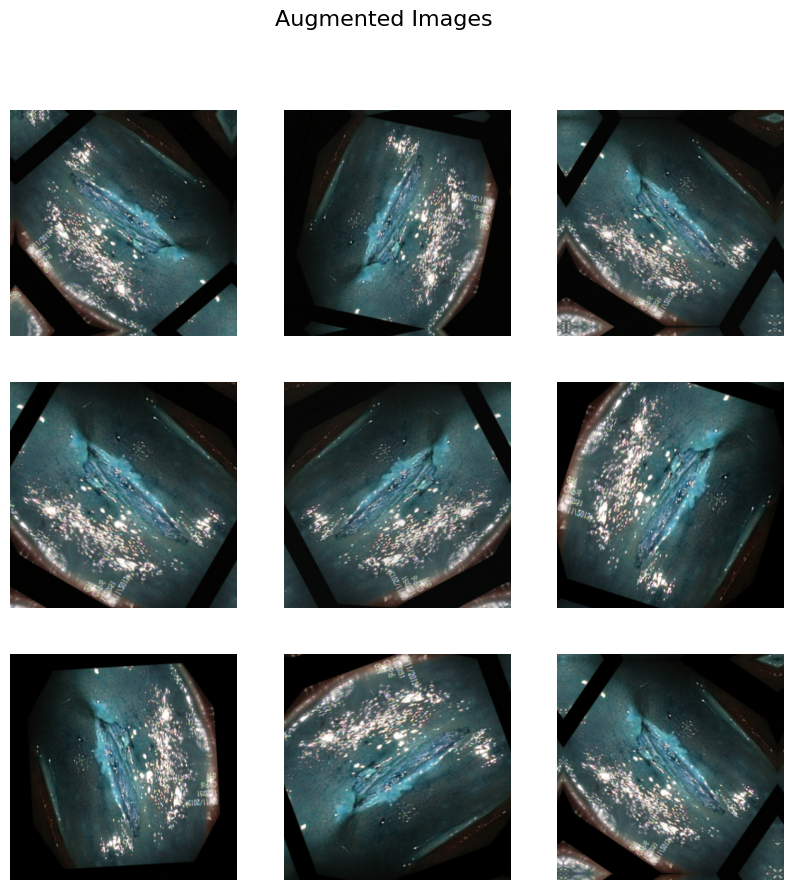

In [15]:
import matplotlib.pyplot as plt
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1)
])

img_path = "/kaggle/input/datasetv2/Datasetv2/test/dyed-resection-margins/0a2a2f35-c798-447c-a883-8f2f448bfe07.jpg"
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(360,360))
img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0  

plt.figure(figsize=(10, 10))
for i in range(9):  
    augmented_img = data_augmentation(tf.expand_dims(img_array, axis=0))  
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_img[0].numpy())
    plt.axis('off')
plt.suptitle("Augmented Images", fontsize=16)
plt.show()

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras import optimizers
from tensorflow.keras import layers, models, regularizers

model = models.Sequential()

# First Convolutional Block
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(360, 360, 3),kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Block
model.add(layers.Conv2D(128, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.001))) # regularizer optional 
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Block
model.add(layers.Conv2D(256, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Fourth Convolutional Block
model.add(layers.Conv2D(512, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten the output and create dense layers
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.4))

model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(len(classes), activation='softmax'))

for layer in model.layers:
    layer.trainable = True

for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

for layer in model.layers[-6:]:
    layer.trainable = True

print("Last few layers are now trainable")

for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4, decay=1e-6),  
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

model.summary()



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


0 conv2d True
1 max_pooling2d True
2 conv2d_1 True
3 max_pooling2d_1 True
4 conv2d_2 True
5 max_pooling2d_2 True
6 conv2d_3 True
7 max_pooling2d_3 True
8 flatten True
9 dense True
10 dropout True
11 dense_1 True
12 dropout_1 True
13 dense_2 True
14 dropout_2 True
15 dense_3 True
Last few layers are now trainable
0 conv2d True
1 max_pooling2d True
2 conv2d_1 True
3 max_pooling2d_1 True
4 conv2d_2 True
5 max_pooling2d_2 True
6 conv2d_3 True
7 max_pooling2d_3 True
8 flatten True
9 dense True
10 dropout True
11 dense_1 True
12 dropout_1 True
13 dense_2 True
14 dropout_2 True
15 dense_3 True


/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 358, 358, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 179, 179, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 177, 177, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 88, 88, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 86, 86, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 43, 43, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 41, 41, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 20, 20, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 204800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   104,858,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,574,344 (406.55 MB)

 Trainable params: 106,574,344 (406.55 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/best_weights.weights.h5', 
    save_best_only=True, 
    save_weights_only=True, 
    verbose=1
)

lr_reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=10,
    verbose=2,
)

In [19]:
history = model.fit(
    train_generator,  
    validation_data=val_generator,  
    epochs=80,  
    callbacks=[checkpoint, lr_reduce]  
)

Epoch 1/80
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.2682 - loss: 3.2157
Epoch 1: val_loss improved from inf to 2.01659, saving model to /kaggle/working/best_weights.weights.h5
320/320 ━━━━━━━━━━━━━━━━━━━━ 227s 637ms/step - accuracy: 0.2684 - loss: 3.2140 - val_accuracy: 0.4187 - val_loss: 2.0166 - learning_rate: 1.0000e-04
Epoch 2/80
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.4154 - loss: 2.0150
Epoch 2: val_loss improved from 2.01659 to 1.51492, saving model to /kaggle/working/best_weights.weights.h5
320/320 ━━━━━━━━━━━━━━━━━━━━ 173s 530ms/step - accuracy: 0.4155 - loss: 2.0146 - val_accuracy: 0.5750 - val_loss: 1.5149 - learning_rate: 1.0000e-04
Epoch 3/80
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.5022 - loss: 1.6616
Epoch 3: val_loss improved from 1.51492 to 1.40828, saving model to /kaggle/working/best_weights.weights.h5
320/320 ━━━━━━━━━━━━━━━━━━━━ 172s 527ms/step - accuracy: 0.5022 - loss: 1.6615 - val_accuracy: 0.5312 - val_loss: 1.40

In [20]:
print("Evaluate on test data")
results = model.evaluate(test_generator)  # Test data generator
print("Test Loss, Test Accuracy:", results)

Evaluate on test data
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 288ms/step - accuracy: 0.7317 - loss: 0.6901
Test Loss, Test Accuracy: [0.6846784949302673, 0.7475000023841858]


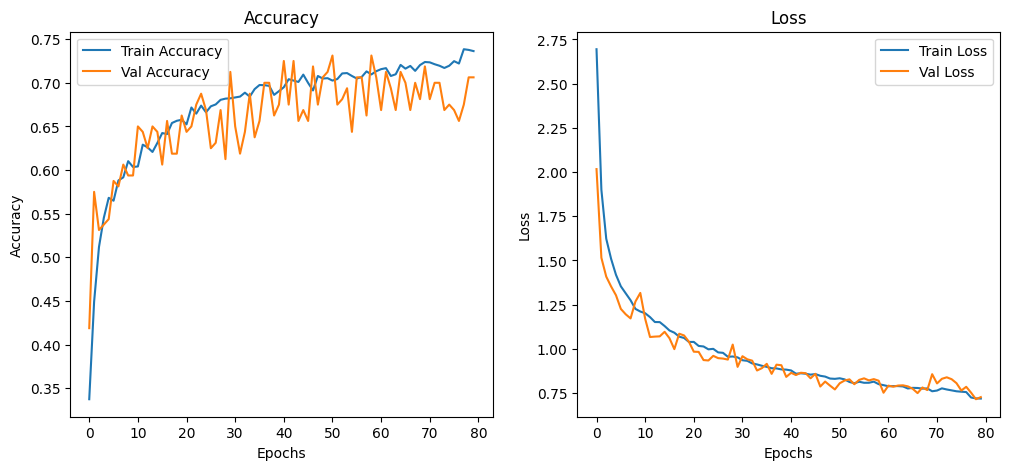

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [22]:
model.save_weights("/kaggle/working/model.weights.h5")
print("Model weights saved successfully!")

Model weights saved successfully!


In [24]:
import numpy as np
from tensorflow.keras.preprocessing import image

image_path = '/kaggle/input/datasetv2/Datasetv2/test/dyed-resection-margins/0d8fee53-37a7-45c9-80e0-25b6e345bae9.jpg'
def preprocess_image(image_path, target_size=(360,360)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

input_image = preprocess_image(image_path)

predictions = model.predict(input_image)

predicted_class = np.argmax(predictions, axis=-1)

class_indices = train_generator.class_indices  
class_labels = {v: k for k, v in class_indices.items()}  

print(f"Predicted class: {class_labels[predicted_class[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
Predicted class: dyed-resection-margins


In [25]:
import numpy as np
from tensorflow.keras.preprocessing import image

image_path = '/kaggle/input/datasetv2/Datasetv2/test/normal-z-line/10e8b9d6-4d34-452f-a909-2d0b52070941.jpg'
def preprocess_image(image_path, target_size=(360,360)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

input_image = preprocess_image(image_path)

predictions = model.predict(input_image)

predicted_class = np.argmax(predictions, axis=-1)

class_indices = train_generator.class_indices  
class_labels = {v: k for k, v in class_indices.items()} 
print(f"Predicted class: {class_labels[predicted_class[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted class: normal-z-line


In [26]:
import numpy as np
from tensorflow.keras.preprocessing import image

image_path = '/kaggle/input/datasetv2/Datasetv2/test/ulcerative-colitis/0e0c04ba-343b-4bd4-a108-70cd09b0075c.jpg'
def preprocess_image(image_path, target_size=(360,360)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

input_image = preprocess_image(image_path)

predictions = model.predict(input_image)

predicted_class = np.argmax(predictions, axis=-1)

class_indices = train_generator.class_indices  
class_labels = {v: k for k, v in class_indices.items()}  

print(f"Predicted class: {class_labels[predicted_class[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted class: ulcerative-colitis


In [44]:
import numpy as np
from tensorflow.keras.preprocessing import image

image_path = '/kaggle/input/datasetv2/Datasetv2/test/esophagitis/1a859df4-b4f0-4a79-86e1-7c3abc7a92cc.jpg'
def preprocess_image(image_path, target_size=(360,360)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

input_image = preprocess_image(image_path)

predictions = model.predict(input_image)

predicted_class = np.argmax(predictions, axis=-1)

class_indices = train_generator.class_indices  
class_labels = {v: k for k, v in class_indices.items()}  

print(f"Predicted class: {class_labels[predicted_class[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted class: esophagitis


In [42]:
import numpy as np
from tensorflow.keras.preprocessing import image

def preprocess_image(image_path, target_size=(360, 360)):
    try:
        img = image.load_img(image_path, target_size=target_size)
        img_array = image.img_to_array(img)
        img_array = img_array / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        return img_array
    except Exception as e:
        print(f"Error in processing image: {e}")
        return None

image_path = input("Please enter the full path to the image file: ")

input_image = preprocess_image(image_path)

if input_image is not None:
    predictions = model.predict(input_image)

    predicted_class = np.argmax(predictions, axis=-1)

    class_indices = train_generator.class_indices  
    class_labels = {v: k for k, v in class_indices.items()}  

    print(f"Predicted class: {class_labels[predicted_class[0]]}")
else:
    print("Failed to preprocess the image. Please check the file path and try again.")


Please enter the full path to the image file:  /kaggle/input/random-imgs/random imgs/esophagitis.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted class: esophagitis


**Unseen Data Prediction**

Please enter the full path to the image file:  /kaggle/input/datasetv2/Datasetv2/test/dyed-lifted-polyps/0714e5ee-8308-43b2-8092-cc2c7b3378fd.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


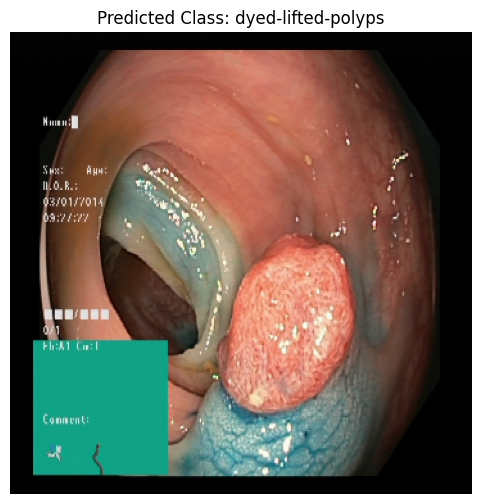

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def preprocess_image(image_path, target_size=(360, 360)):
    try:
        img = image.load_img(image_path, target_size=target_size)
        img_array = image.img_to_array(img)
        img_array = img_array / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        return img, img_array
    except Exception as e:
        print(f"Error in processing image: {e}")
        return None, None

image_path = input("Please enter the full path to the image file: ")

original_image, input_image = preprocess_image(image_path)

if input_image is not None:
    predictions = model.predict(input_image)

    predicted_class = np.argmax(predictions, axis=-1)

    class_indices = train_generator.class_indices  
    class_labels = {v: k for k, v in class_indices.items()}  

    predicted_label = class_labels[predicted_class[0]]

    plt.figure(figsize=(6, 6))
    plt.imshow(original_image)
    plt.axis('off')
    plt.title(f"Predicted Class: {predicted_label}")
    plt.show()
else:
    print("Failed to preprocess the image. Please check the file path and try again.")
